Implemented using this paper: https://arxiv.org/pdf/0706.0304.pdf

# Imports

In [2]:
import qiskit
from qiskit import *
qiskit.__qiskit_version__

import numpy as np
from qiskit.tools.visualization import plot_histogram, plot_state_city

import matplotlib as mpl
import matplotlib.pyplot as plot

# Parameters

In [25]:
#number of qubits dedicated for each axis, 2n qubits total
n = 5

#number of iterations/walks to be performed
step = 17

# Construct circuit

In [26]:
#define registers
qnodes = QuantumRegister(2 * n,'qc')
qsubnodes = QuantumRegister(2,'qanc')
cnodes = ClassicalRegister(2 * n,'cr')

def prep_symmetric_coins(qwc, qubit):
    for q in qubit:
        qwc.ry(np.pi/2, q)
        qwc.p(np.pi/2, q)

#clockwise rotation, adder circuit like
def increment_gate(qwc, q, subnodes, coord = 'x'):
    offset = 0
    if (coord == 'y'):
        offset = n
        qwc.x(subnodes[1])
    for t in range(n):
        tgt = t + offset
        control = []
        for i in range(t + offset + 1, n + offset):
            control.append(q[i])
        control.append(subnodes[0])
        control.append(subnodes[1])
        qwc.mct(control, tgt)
    if (coord == 'y'):
        qwc.x(subnodes[1])
    qwc.barrier()
        

#counterclockwise rotation, subtractor circuit like
def decrement_gate(qwc, q, subnodes, coord):
    qwc.x(subnodes[0])
    offset = 0
    if (coord == 'y'):
        offset = n
    else:
        qwc.x(subnodes[1])
    for i in range(offset + 1, n + offset):
        qwc.x(q[i])
    for t in range(n):
        if (t != 0):
            qwc.x(q[t + offset])
        tgt = t + offset
        control = []
        for i in range(t + offset + 1, n + offset):
            control.append(q[i])
        control.append(subnodes[0])
        control.append(subnodes[1])
        qwc.mct(control, tgt)
    if (coord != 'y'):
        qwc.x(subnodes[1])
    qwc.x(subnodes[0])
    qwc.barrier()

def buildQWC(qwc, times):
    for i in range(times):
        qwc.h(qsubnodes[0])
        qwc.h(qsubnodes[1])
        #"coinflip" applied to the subnode every iteration
        increment_gate(qwc, qnodes, qsubnodes, coord = 'x')
        decrement_gate(qwc, qnodes, qsubnodes, coord = 'x')
        increment_gate(qwc, qnodes, qsubnodes, coord = 'y')
        decrement_gate(qwc, qnodes, qsubnodes, coord = 'y')
    qwc.measure(qnodes, cnodes)

qwc = QuantumCircuit(qnodes, qsubnodes, cnodes)

prep_symmetric_coins(qwc, qsubnodes)

#build circuit
buildQWC(qwc, step)

#qwc.draw()

# Run circuit

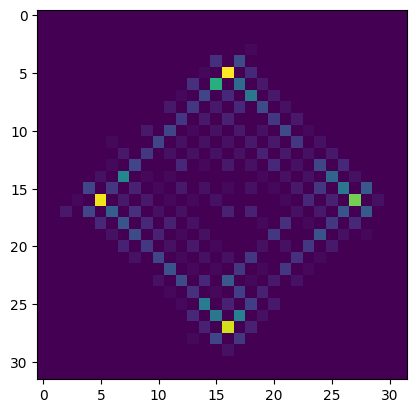

In [28]:
def toDec(string):
    dec = int(string, 2)
    if (string[0] == "1"):
        dec -= 2 ** len(string) 
    return dec

def aersim(circ):
      sim = Aer.get_backend('aer_simulator')
      return execute(circ, sim, shots=1000).result().get_counts(circ)

def ionq(circ):
    backend = provider.get_backend("ionq.simulator")
    #backend = provider.get_backend("ionq.qpu")
    job = backend.run(circ, shots=1000)
    print("Job id:", job.id())
    res = job.result()
    return res.get_counts()


# ------

result = aersim(qwc)

# ------

#display results as heatmap
mat = np.zeros(shape=(2**n,2**n), dtype=int)
for r in result:
    #flip bits
    b = r[::-1]
    #first n bits are x
    x = b[0:n]
    #last n bits are y
    y = b[n:2*n]
    mat[toDec(x) + 2**(n-1),toDec(y) + 2**(n-1)] = result[r]

plot.imshow(mat)